In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import cv2
import time
import os
from copy import deepcopy

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from glob import glob

import fastai.vision.transform as tr
from fastai.vision import *

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'D:\\downloads\\data\\data\\train'

with open('broken.txt', 'r') as f:
    broken = [int(a.strip()) for a in f.read().split()]

df = pd.read_csv(os.path.join(path, 'landmarks.csv'), sep='\t', nrows=1)
dtypes = {p : np.int16 for p in df.columns.values}
dtypes['file_name'] = 'str'
df = pd.read_csv(os.path.join(path, 'landmarks.csv'), sep='\t', dtype=dtypes, nrows=10000)
print(len(df))
df = df[~df.index.isin(broken)].reset_index(drop=True)
print(len(df))
n = 8000
train_df = df.iloc[:n].reset_index(drop=True)
val_df = df.iloc[n:].reset_index(drop=True)
del df

N_CLASSES = 1942

10000
9966


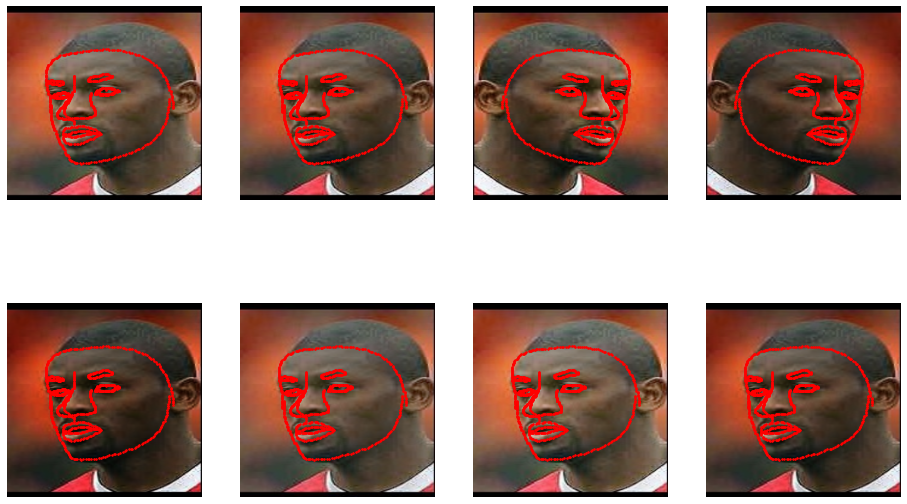

In [3]:
def get_points(values, size):
    points = np.array(values, dtype=np.int16).reshape(-1, 2)
    points[:, 0], points[:, 1] = points[:, 1], points[:, 0].copy()
    points = ImagePoints(FlowField(size, points), scale=True)
    return points

tfms = get_transforms(max_zoom=1, p_affine=0, max_warp=0)

def plots_f(rows, cols, width, height, tfms, **kwargs):
    [img.apply_tfms(tfms, **kwargs).show(ax=ax, y=points.apply_tfms(tfms, do_resolve=False, **kwargs))
     for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]


# img.show(y=ImagePoints(scale_flow(FlowField(img.size, res.reshape(-1, 2)), to_unit=False), scale=True))

sample = train_df.iloc[1433]
file = sample[0]
img = open_image(os.path.join(path, 'images', file))
points = get_points(sample[1:], img.size)
kp = points.data.clone()

plots_f(2, 4, 16, 10, size=224, tfms=tfms[0], resize_method=ResizeMethod.SQUISH)

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

class FacesLandmarks(Dataset):
    def __init__(self, df, img_path=os.path.join(path, 'images'), transforms=None):
        self.df = df
        self.path = img_path
        self.transforms = transforms

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        img = open_image(f"{self.path}/{sample[0]}")
        points = get_points(sample[1:], img.size)
        size = 224
        
        img = img.apply_tfms(self.transforms, size=224, resize_method=ResizeMethod.SQUISH)
        img = normalize(img.data)
        points = points.apply_tfms(self.transforms, do_resolve=False, size=224, resize_method=ResizeMethod.SQUISH)
        pts = points.data.reshape(-1)
        
        if len(pts) != N_CLASSES:
            return self.__getitem__((idx + 1) % len(self))
        
        return img, pts

    def __len__(self):
        return len(self.df.index)

In [ ]:
BATCH_SIZE = 32

train_tfms, val_tfms = get_transforms(max_zoom=1)
train_dataset = FacesLandmarks(train_df, transforms=None)
val_dataset = FacesLandmarks(val_df, transforms=None)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

dataloaders = {
    'train' : train_loader,
    'val' : val_loader
}

dataset_sizes = {
    'train' : len(train_df),
    'val' : len(val_df)
}

In [ ]:
# broken = []
# for i in tqdm(range(len(train_dataset)), total=len(train_dataset)):
#     a, b = train_dataset[i]
#     if len(b) != 1942:
#         broken.append(i)

# with open('broken.txt', 'w') as f:
#     f.write('\n'.join([str(i) for i in broken]))

In [ ]:
import torchvision.models as models
# resnext = models.resnext50_32x4d(pretrained=True)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, N_CLASSES, bias=True)

In [22]:
# for a in base.parameters():
#     a.requires_grad = False

In [42]:
model.load_state_dict(torch.load('resnet18_1_epoch.pth'))
device = torch.device('cuda')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3)
loss_fn = nn.MSELoss()

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.8f}")

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    print(f"Best val loss: {best_loss:8f}")

    model.load_state_dict(best_model_wts)
    return model

In [78]:
for a, b in tqdm(train_loader):
    c = a

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.41it/s]


In [73]:
best_model = train_model(model, loss_fn, optimizer, scheduler, num_epochs=1)

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Epoch 0/0
------------------------------


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

train Loss: 0.00001411


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]

val Loss: 0.00004615

Training completed in 0m 24s
Best val loss: 0.000046


In [30]:
# model.eval()

# i = 0
# running_loss = 0
# for batch, target in tqdm(val_loader):
#     outputs = model(batch.to(device))                
#     loss = loss_fn(outputs, target.to(device))
#     running_loss += loss.item() * batch.size(0)

In [74]:
# torch.save(model.state_dict(), f'resnext_idk.pth')
model.eval();

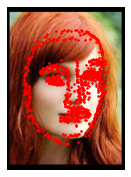

In [75]:
sample = train_df.iloc[0]
file = sample[0]
img = open_image(os.path.join(path, 'images', file))
img_tf = img.apply_tfms(None, size=224, resize_method=ResizeMethod.SQUISH)
data = normalize(img_tf.data)

res = model(data[None, :, :, :].to(device)).detach().cpu()
img.show(y=ImagePoints(scale_flow(FlowField(img.size, res.reshape(-1, 2)), to_unit=False), scale=True))

In [57]:
scale_flow(FlowField(img.size, res.reshape(-1, 2)), to_unit=False).flow
scale_flow(FlowField(img.size, train_dataset[0][1].reshape(-1, 2)), to_unit=False).flow
loss_fn((train_dataset[0][1] + 1), res.reshape(-1))

tensor([[311., 162.],
        [311., 159.],
        [311., 156.],
        ...,
        [254., 123.],
        [163., 112.],
        [166., 191.]])

In [76]:
sh = 224
a = (train_dataset[0][1]).reshape(-1, 2) * sh
b = (res).reshape(-1, 2) * sh

loss_fn(a.reshape(-1), b.reshape(-1))

tensor(97.0174)

In [61]:
s = tensor([flow.size[0]/2,flow.size[1]/2])[None]
if to_unit: flow.flow = flow.flow/s-1
else:       flow.flow = (flow.flow+1)*s

622.0060000000001

In [65]:
(train_dataset[0][1][:2] + 1) * ()

tensor([311.0000, 162.0000], dtype=torch.float64)

In [ ]:
def process_output(output, flip=True):
    tmp = scale_flow(FlowField(img.size, output.detach().cpu().reshape(-1, 2)), to_unit=False).flow.int()
    if flip:
        tmp[:, 0], tmp[:, 1] = tmp[:, 1], tmp[:, 0].clone()
    return tmp.reshape(-1).numpy()
# tmp = process_output(model(img.apply_tfms(None, size=224, resize_method=ResizeMethod.SQUISH).data[None, :, :, :].to(device)), flip=True)

In [ ]:
sample_sub = pd.read_csv('sampleSubmission.csv', index_col='file_name')
test_df = pd.read_csv('test_points.csv', sep='\t')

class TestFacesLandmarks(Dataset):
    def __init__(self, df, img_path='data/test/images'):
        self.df = df
        self.path = img_path

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        img = open_image(f"{self.path}/{sample[0]}")
        point_indices = sample[1]
        size = 224
        
        img = img.apply_tfms(None, size=224, resize_method=ResizeMethod.SQUISH)
        img = normalize(img)
        return img.data, np.array([[2 * i, 2 * i + 1] for i in eval(point_indices)]).reshape(-1)

    def __len__(self):
        return len(self.df.index)

test_dataset = TestFacesLandmarks(test_df)
n = len(test_dataset)

for i in tqdm(range(n), total=n):
    x, idx = test_dataset[i]
    res = process_output(model(x[None, :, :, :].to(device)))[idx]
    sample_sub.iloc[i] = res

In [ ]:
sample_sub.to_csv('sub_resnext.csv')

In [ ]:
!head sub_resnext.csv

In [ ]:
# !kaggle competitions submit -c made-thousand-facial-landmarks -f sub0.csv -m "1h of learning"

In [ ]:
1